In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

'''
from google.colab import drive
drive.mount('/content/drive')
'''

# Set some parameters
BATCH_SIZE = 5 # the higher the better
IMG_WIDTH = 512 # for faster computing on kaggle
IMG_HEIGHT = 512 # for faster computing on kaggle
IMG_CHANNELS = 3

#TRAIN_PATH = '/content/drive/My Drive/UNet/Cell'
#TEST_PATH = '/content/drive/My Drive/UNet/Cell'

TRAIN_PATH = './Cell/'
TEST_PATH = './Cell/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

/home/chenzhong/miniconda3/envs/resnet_anzhe/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_train = np.load('X.npy')
Y_train = np.load('Y.npy')

In [3]:
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel

# os.environ['MASTER_ADDR'] = 'localhost'
# os.environ['MASTER_PORT'] = '12355'
# os.environ['WORLD_SIZE'] = '20'
# os.environ['RANK'] = '0'
# dist.init_process_group(backend='nccl')

#x, y, x_val, y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=seed)
#split dataset to 80% 10% 10%
split_ratio = 0.8
split_idx = int(X_train.shape[0] * split_ratio)

x = X_train[:split_idx]
y = Y_train[:split_idx]
x_val = X_train[split_idx:]
y_val = Y_train[split_idx:]

test_ratio = 0.5
split_test = int(x_val.shape[0]*test_ratio)

X_test = x_val[split_test:]
#test_ids = X_test

x_val = x_val[:split_test]
y_val = y_val[:split_test]

# print(x.shape)
# print(y.shape)

########when label is matched delete this#######################
#x = x[:93]
#x_val = x_val[:93]
################################################################
x_train_tensor = torch.from_numpy(x)
y_train_tensor = torch.from_numpy(y)
# x_train_tensor = torch.tensor(x_train_tensor, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train_tensor, dtype=torch.float32)
x_train_tensor = x_train_tensor.to(torch.float32).clone().detach().requires_grad_(True)
y_train_tensor = y_train_tensor.to(torch.float32).clone().detach().requires_grad_(True)
#print(x_train_tensor.shape)
#print(y_train_tensor.shape)
x_val_tensor = torch.from_numpy(x_val)
y_val_tensor = torch.from_numpy(y_val)
# x_val_tensor = torch.tensor(x_val_tensor, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val_tensor, dtype=torch.float32)
x_val_tensor = x_val_tensor.to(torch.float32).clone().detach().requires_grad_(True)
y_val_tensor = y_val_tensor.to(torch.float32).clone().detach().requires_grad_(True)

train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# train_sampler = torch.utils.data.distributed.DistributedSampler(train_dataset)
# val_sampler = torch.utils.data.distributed.DistributedSampler(val_dataset)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


In [4]:
def show_mask(mask, title=None):
    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(mask, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()

/tmp/ipykernel_2810372/964283756.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 3)


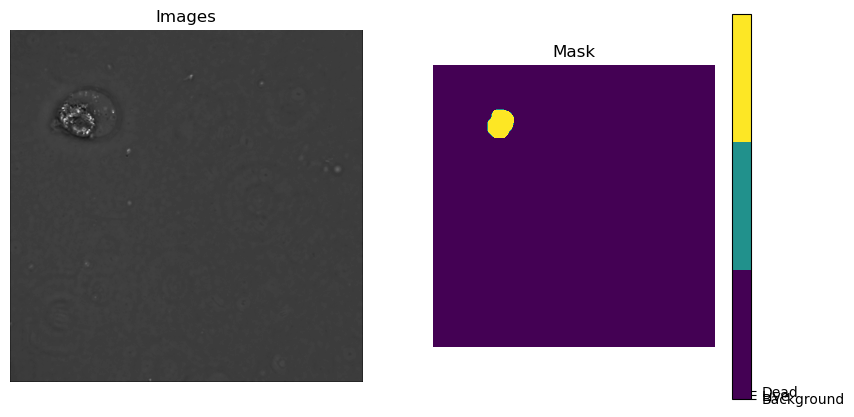

/tmp/ipykernel_2810372/964283756.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 3)


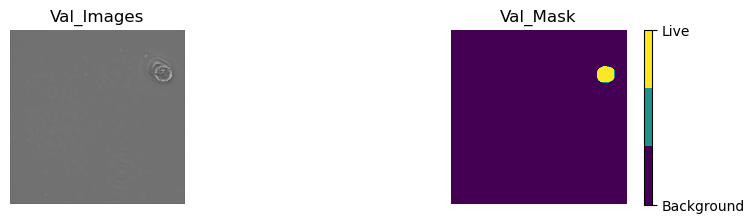

In [5]:

import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x[5,:,:,0], cmap='gray')
plt.title("Images")
plt.axis('off')

plt.subplot(1, 2, 2)
show_mask(y[5],"Mask")

plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
plt.imshow(x_val[5,:,:,0], cmap='gray')
plt.title("Val_Images")
plt.axis('off')

plt.subplot(2, 2, 2)
show_mask(y_val[5],"Val_Mask")
#creating a training and validation generator that generate masks and images
#train_generator = zip(x, y)
#val_generator = zip(x_val, y_val)


In [6]:
# Define IoU metric
import torch

# def mean_iou(y_pred, y_true):
#     num_classes = y_true.size(1)
#     ious = []
    
#     for cls in range(num_classes):
#         intersection = torch.logical_and(y_true[:, cls, :, :], y_pred[:, cls, :, :]).sum()
#         union = torch.logical_or(y_true[:, cls, :, :], y_pred[:, cls, :, :]).sum()

#         iou = (intersection.float() + 1e-10) / (union.float() + 1e-10)
#         ious.append(iou)

#     mean_iou = torch.mean(torch.stack(ious))
#     return mean_iou.item()

def mean_iou(y_pred, y_true, num_classes=3):
    prec = []
    
    for class_id in range(num_classes):
        intersection = torch.sum((y_true == class_id) & (y_pred == class_id))
        union = torch.sum((y_true == class_id) | (y_pred == class_id))
        
        # Ensure union is not zero
        union = torch.where(union == 0, torch.ones_like(union), union)
        
        iou = intersection.float() / union.float()
        prec.append(iou.item()) 
        
    return torch.mean(torch.tensor(prec))



In [7]:
class SelfAttention(nn.Module):
    def __init__(self, channels, size):
        super(SelfAttention, self).__init__()
        self.channels = channels
        self.size = size
        self.mha = nn.MultiheadAttention(channels, 4, batch_first=True)
        self.ln = nn.LayerNorm([channels])
        self.ff_self = nn.Sequential(
            nn.LayerNorm([channels]),
            nn.Linear(channels, channels),
            nn.GELU(),
            nn.Linear(channels, channels),
        )

    def forward(self, x):
        x = x.view(-1, self.channels, self.size * self.size).swapaxes(1, 2)
        x_ln = self.ln(x)
        attention_value, _ = self.mha(x_ln, x_ln, x_ln)
        attention_value = attention_value + x
        attention_value = self.ff_self(attention_value) + attention_value
        return attention_value.swapaxes(2, 1).view(-1, self.channels, self.size, self.size)

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels=None, residual=False):
        super(ConvBlock, self).__init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, mid_channels),
            nn.GELU(),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.GroupNorm(1, out_channels),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.conv_block(x))
        else:
            return self.conv_block(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(DownSample, self).__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x):
        x = self.maxpool_conv(x)
        return x

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels, emb_dim=256):
        super(UpSample, self).__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.out_channels = out_channels
        self.conv = nn.Sequential(
            ConvBlock(in_channels, in_channels, residual=True),
            ConvBlock(in_channels, out_channels, in_channels // 2),
        )

        self.emb_layer = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_dim, out_channels),
        )

    def forward(self, x, skip_x):

        x = self.upsample(x)
        #print(x.shape)
        #print(skip_x.shape)
        x = torch.cat([skip_x, x], dim=1)
        x = self.conv(x)
        #emb = self.emb_layer(t)[:, :, None, None].expand(-1, -1, x.shape[-2], x.shape[-1])
        return x

class UNet(nn.Module):
    def __init__(self, c_in=3, c_out=3):
        super(UNet, self).__init__()
        self.initial_conv = ConvBlock(c_in, 64)
        self.downsample1 = DownSample(64, 128)
        self.self_attention1 = SelfAttention(128, 128)
        self.downsample2 = DownSample(128, 256)
        self.self_attention2 = SelfAttention(256, 256)
        self.downsample3 = DownSample(256, 256)
        self.self_attention3 = SelfAttention(256, 256)

        self.bottom1 = ConvBlock(256, 512)
        self.bottom2 = ConvBlock(512, 512)
        self.bottom3 = ConvBlock(512, 256)

        self.upsample1 = UpSample(512, 128)
        self.self_attention4 = SelfAttention(128, 128)
        self.upsample2 = UpSample(256, 64)
        self.self_attention5 = SelfAttention(64, 64)
        self.upsample3 = UpSample(128, 64)
        self.self_attention6 = SelfAttention(64, 64)
        self.output_conv = nn.Conv2d(64, c_out, kernel_size=1)

    def forward(self, x):

        x1 = self.initial_conv(x)
        x2 = self.downsample1(x1)
        #x2 = self.self_attention1(x2)
        x3 = self.downsample2(x2)
        #x3 = self.self_attention2(x3)
        x4 = self.downsample3(x3)
        #x4 = self.self_attention3(x4)

        x4 = self.bottom1(x4)
        x4 = self.bottom2(x4)
        x4 = self.bottom3(x4)

        x = self.upsample1(x4, x3)
        #x = self.self_attention4(x)
        x = self.upsample2(x, x2)
        #x = self.self_attention5(x)
        x = self.upsample3(x, x1)
        #x = self.self_attention6(x)
        output = self.output_conv(x)
        return output

In [8]:
#define early stopping
class EarlyStopping:
    def __init__(self, patience=3, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_score is None:
            self.best_score = val_loss
            self.save_checkpoint(model)
        elif val_loss > self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = val_loss
            self.save_checkpoint(model)
            self.counter = 0
        return self.early_stop

    def save_checkpoint(self, model):
        if self.verbose:
            print(f'Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pth')


In [9]:
def jaccard_loss(pred, target):
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    jaccard_loss = 1.0 - (intersection + 1) / (union + 1) 
    return jaccard_loss

In [10]:
import torch.backends.cudnn as cudnn

c_in = 3  # input channel 3 for RGB
c_out = 1  # output channel
if torch.cuda.device_count() > 1:
    device2 = torch.device("cuda:0")
    device1 = torch.device("cuda:1")
else:
    raise RuntimeError("Multiple GPUs are required.")

model = UNet(c_in, c_out)
checkpoint = torch.load('checkpoint.pth')
modified_state_dict = {key.replace('module.', ''): value for key, value in checkpoint.items()}
model.load_state_dict(modified_state_dict)
#cudnn.benchmark = True
#model = torch.nn.DataParallel(model)

class ThreeChannelLogitsLoss(nn.Module):
    def __init__(self):
        super(ThreeChannelLogitsLoss, self).__init__()

    def forward(self, output, target):
        loss = 0
        for i in range(c_out):
            loss += nn.BCEWithLogitsLoss()(output[:, i, :, :], target[:, i, :, :])
        return loss / c_out

#criterion = ThreeChannelLogitsLoss()
criterion = nn.L1Loss()    
#criterion = nn.CrossEntropyLoss()
#criterion = jaccard_loss
#criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5, verbose=True)
scheduler =  torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)


In [11]:
# #print unet model summary

# from torchsummary import summary

# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters() if p.requires_grad)

# #print(model)
# #print(f"Total Trainable Parameters: {count_parameters(model)}")
# summary(model, (3, 128, 128), device= 'cpu')


In [12]:

# Training loop
num_epochs = 100
model.to(device1)
best_loss = 1.0
best_iou = 0.0
log_file = open("training_log_new_2.txt", "w")
for epoch in range(0,num_epochs):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    for i,(inputs, labels) in enumerate(tqdm(train_loader)):
        gpu = torch.cuda.get_device_properties(device1)
        #print(f'{device1}: {gpu.name}, Total Memory: {gpu.total_memory / 1024**2:.2f} MB, Free Memory: {torch.cuda.max_memory_allocated(device1) / 1024**2:.2f} MB')
        #print(torch.cuda.memory_allocated(device1))
        #print(torch.cuda.max_memory_allocated(device1))
        if torch.cuda.memory_allocated(device1) > 0.9 * gpu.total_memory:
            model = model.to(device2)
            device1, device2 = device2, device1
            print('changed gpu')
            #inputs, labels = inputs.to(device1), labels.to(device1)
            model = model.to(device1)
            
        inputs, labels = inputs.permute(0, 3, 1, 2).to(device1), labels.permute(0, 3, 1, 2).to(device1)
        #print(inputs.shape)
        #print(labels.shape)
        optimizer.zero_grad()
        outputs = model(inputs)
        iou = mean_iou(outputs, labels)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_iou += iou.item()

        if i % 50 == 0 and i != 0:
            print(f"Epoch {epoch+1}: Batch[{i}/{len(train_loader)}] Loss: {total_loss / i} IoU: {total_iou / i}")
            if i % 100 == 0:
                print(f'Saving model...')
                torch.save(model.state_dict(), 'checkpoint.pth')
    avg_loss = total_loss / len(train_loader)
    avg_iou = total_iou / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss} IoU: {avg_iou}")

    best_loss = min(best_loss,avg_loss)
    best_iou = max(best_iou,avg_iou)

    log_file.write(f"Epoch [{epoch+1}/{num_epochs}] Loss: {avg_loss} IoU: {avg_iou}\n")
    log_file.write(f'Best loss: {best_loss}, Best IoU: {best_iou}\n\n')
    log_file.flush()

    if early_stopping(avg_loss, model):
        print('Early stopping triggered')
        break
print(f'Best loss is {best_loss}, best iou is {best_iou}')


 28%|██▊       | 51/179 [04:16<10:50,  5.08s/it]

Epoch 1: Batch[50/179] Loss: 0.7089917917316779 IoU: 1.5517647653950916e-06


 56%|█████▌    | 100/179 [08:22<06:27,  4.90s/it]

Epoch 1: Batch[100/179] Loss: 0.780531966316048 IoU: 1.2577153540860309e-06
Saving model...


 79%|███████▉  | 142/179 [11:45<02:45,  4.48s/it]

In [ ]:
model = model.to(device2)
model.eval()
with torch.no_grad():
    for inputs in tqdm(val_loader):
        inputs = inputs[0].permute(0, 3, 1, 2).to(device2)
        outputs = model(inputs)
#torch.save(model.state_dict(),'cell_segment.pth')
#prediction
#X_train = torch.Tensor(X_train).permute(0, 3, 1, 2).to(device)
model=model.to(device1)
X_test = torch.Tensor(X_test).permute(0, 3, 1, 2)
val_X = x_val_tensor.permute(0,3,1,2)
with torch.no_grad():
    #preds_train = model(X_train[:int(X_train.shape[0]*0.9)])
    #preds_val = model(X_train[int(X_train.shape[0]*0.9):])
    #preds_train = model(x_train_tensor.permute(0,3,1,2).to(device2))
    preds_val = model(val_X[:int(val_X.shape[0]*0.06)].to(device1))
    preds_test = model(X_test[:int(X_test.shape[0]*0.06)].to(device1))


# Threshold predictions
threshold = 0.5
#preds_train_t = (preds_train > threshold).byte()
preds_val_t = (preds_val > threshold)
preds_test_t = (preds_test > threshold)

# # Create a list of upsampled test masks
# preds_test_upsampled = []
# for i in range(len(preds_test)):
#     preds_test_upsampled.append(np.squeeze(preds_test_t[i]))


In [ ]:
import random
import matplotlib.pyplot as plt

X_test = torch.Tensor(X_test).permute(0, 2, 3, 1)


In [ ]:
random_index = random.randint(0, len(preds_test_t) - 1)
test_image = X_test[random_index,:, :, 0].cpu()
predicted_mask = preds_test_t[random_index].cpu().numpy()
# predicted_mask_1 = preds_test_t[random_index][0].cpu().numpy()
# predicted_mask_2 = preds_test_t[random_index][1].cpu().numpy()

# predicted_mask = np.zeros_like(predicted_mask_1,dtype=np.uint8)
# predicted_mask[predicted_mask_1>0] = [255,255,0]
# predicted_mask[predicted_mask_2>0] = [128,0,128]

predicted_mask = np.transpose(predicted_mask, (1, 2, 0))

# print(test_image.shape)
# print(predicted_mask.shape)
#plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
#plt.imshow(test_image, cmap='gray')
plt.imshow(test_image, cmap='gray')
plt.title("Test Image")
plt.axis('off')

plt.subplot(1, 2, 2)
# plt.imshow(predicted_mask)
# plt.title("Predicted Mask")
show_mask(predicted_mask,"Predicted Mask")
plt.axis('off')

plt.show()


In [ ]:
for i in range(len(preds_test_t) - 1):
    predicted_mask = preds_test_t[i].cpu().numpy()
    predicted_mask = np.transpose(predicted_mask, (1, 2, 0))

    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(predicted_mask, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2]) 
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    
    mask_name = os.path.join('./result/test', f'predicted_mask_{i}.jpg')
    image_name = os.path.join('./result/test', f'image_{i}.jpg')

    plt.savefig(mask_name) 
    plt.close()  

    plt.imshow(X_test[i,:, :, 0].cpu(), cmap='gray')
    plt.axis('off')
    plt.savefig(image_name)  
    plt.close() 

In [ ]:
# for i in range(4):
#     predicted_mask = preds_test_t[i].cpu().numpy()
#     predicted_mask = np.transpose(predicted_mask, (1, 2, 0))
#     mask1 = predicted_mask[..., 0]  # Assuming the first mask is at index 0
#     mask2 = predicted_mask[..., 1]  # Assuming the second mask is at index 1
#     if mask2.any()>0:
#         print(True)
#     # plt.subplot(i+1, 2, 1)
#     # plt.imshow(mask1,cmap='gray')
#     # plt.subplot(i+1, 2, 2)
#     # plt.imshow(mask2,cmap='gray')

In [ ]:
'''
import random
import torch
import matplotlib.pyplot as plt

# Define a function to display images
def imshow_tensor(tensor):
    # Ensure the tensor is on the CPU and convert it to a NumPy array
    #tensor = tensor.cpu().numpy()

    # If the tensor is 3D (C, H, W) and has a single channel, squeeze it to (H, W)
    if len(tensor.shape) == 3 and tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)

    # Display the image
    plt.imshow(tensor, cmap='gray')
    plt.show()

# Move your tensors to CPU (if they are not already)
X_train_cpu = x
Y_train_cpu = y

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow_tensor(X_train_cpu[ix])
imshow_tensor(Y_train_cpu[ix])
imshow_tensor(preds_train_t[ix].cpu())
'''


In [ ]:
import random
import torch
import matplotlib.pyplot as plt

# Define a function to display images
def imshow_tensor(tensor):
    # Ensure the tensor is on the CPU and convert it to a NumPy array
    #tensor = tensor.cpu().numpy()

    # If the tensor is 3D (C, H, W) and has a single channel, squeeze it to (H, W)
    if len(tensor.shape) == 3 and tensor.shape[0] == 1:
        tensor = tensor.squeeze(0)
    
    if tensor.shape[0] == 3:
        tensor = np.transpose(tensor, (1, 2, 0))

    # Display the image
    plt.imshow(tensor, cmap='gray')
    plt.show()

# Move your tensors to CPU (if they are not already)
X_val_cpu = x_val
Y_val_cpu = y_val

# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_val_t)-1)
predicted_val_mask = preds_val_t[ix].cpu().numpy()
predicted_val_mask = np.transpose(predicted_val_mask,(1,2,0))

imshow_tensor(X_val_cpu[ix,:,:,0])
#imshow_tensor(Y_val_cpu[ix])
show_mask(Y_val_cpu[ix])
#imshow_tensor(np.squeeze(preds_val[ix]).cpu().astype(np.float32) / 255.0)
show_mask(predicted_val_mask)

In [ ]:
import cv2

for i in range(len(preds_val_t) - 1):
    predicted_mask = preds_val_t[i].cpu().numpy()
    predicted_mask = np.transpose(predicted_mask, (1, 2, 0))
    
    ground_show = Y_val_cpu[i,:,:,0]

    mask_name = os.path.join('./result/val', f'predicted_mask_{i}.jpg')
    image_name = os.path.join('./result/val', f'image_{i}.jpg')
    ground_name = os.path.join('./result/val', f'ground_truth_{i}.jpg')

    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(predicted_mask, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2]) 
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    
    plt.savefig(mask_name)
    plt.close()

    plt.imshow(X_val_cpu[i, :, :, 0], cmap='gray')
    plt.axis('off')
    plt.savefig(image_name)
    plt.close()

    cmap = plt.cm.colors.ListedColormap(['black', 'green', 'yellow'])  
    bounds = [-0.5, 0.5, 1.5, 2.5]  
    norm = plt.cm.colors.BoundaryNorm(bounds, cmap.N)
    
    plt.imshow(ground_show, cmap=cmap, norm=norm)
    cbar = plt.colorbar(ticks=[0, 1, 2]) 
    cbar.ax.set_yticklabels(['Background', 'Live', 'Dead'])
    plt.axis('off')
    plt.savefig(ground_name)
    plt.close()


In [ ]:
# # Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# def rle_encoding(x):
#     dots = np.where(x.T.flatten() == 1)[0]
#     run_lengths = []
#     prev = -2
#     for b in dots:
#         if (b>prev+1): run_lengths.extend((b + 1, 0))
#         run_lengths[-1] += 1
#         prev = b
#     return run_lengths

# def prob_to_rles(x, cutoff=0.5):
#     lab_img = label(x > cutoff)
#     for i in range(1, lab_img.max() + 1):
#         yield rle_encoding(lab_img == i)
# new_test_ids = []
# rles = []
# for n, id_ in enumerate(test_ids):
#     if n > len(preds_test_t) - 1:
#         n = len(preds_test_t) - 1
#     rle = list(prob_to_rles(preds_test_t[n].cpu()))
#     rles.extend(rle)
#     new_test_ids.extend([id_] * len(rle))
#print(rles)

In [ ]:
# import torch.onnx

# dummy_input = torch.randn(1, 3, 128, 128).to(device1)

# model.eval()

# onnx_file_path = "unet_model.onnx"
# torch.onnx.export(model, dummy_input, onnx_file_path, verbose=False)

# print(f"ONNX saved in: {onnx_file_path}")



In [ ]:
# image =X.to(device2)
# output = model(image)